In [183]:
%load_ext autoreload
%autoreload

import pandas as pd; pd.set_option('display.max_columns', 30); pd.set_option('display.max_rows', 100)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import ptsa
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/SWRrefactored/code/SWR_modules/')
from SWRmodule import *
from general import * #superVstack,findInd,findAinB
from power_functions import z_score, process_power, load_z_scored_power

base = '/home1/john/SWRrefactored'
sys.path.append(f'{base}/code/')

from load_data_numpy import load_data_np
from SWRmodule import triangleSmooth
# from comodulogram import remove_session_string, get_filtered_signal
# from fooof import FOOOF

import statsmodels.formula.api as smf
from scipy.signal import decimate, resample, hilbert, welch, spectrogram
from mne.time_frequency import tfr_array_morlet

# # Import the time & event model objects and Bands object to manage oscillation band definitions
# from specparam import SpectralTimeModel, SpectralTimeEventModel, Bands
# # Import helper utilities for simulating and plotting spectrograms
# from specparam.sim import sim_spectrogram
# from specparam.plts.spectra import plot_spectrogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
# for now the plotting code only works with one region at a time
region_name = ['ENT'] # ['ENT'] # ['AMY'] ['HPC']
subregion = [''] #['ca1'] # can use [''] to select ALL subregions
task = 'catFR1' # 'catFR1'
savePath = f'{base}/figures/'

# 1 for encoding, 0 for recall
encoding_mode_arr = [0] #,1] #[0,1] 
freq_range_str_arr = [[2,4]] #,[7,9],[33.5,75],[80,120]] #[[33.5,75],[80,120]] #,[2,4],[7,9]] # [80,178]
# these were selecetd to avoid 60 and 120 Hz using np.logspace(np.log10(30),np.log10(75),10)

fs = 500 # sampling rate for raw data and ripples from createEventsForDF.py

In [144]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)

    region_str = region_name[0]
    subregion_str = subregion[0]
    
    clust = dd_trials['clust_int']
    
    start_cutoff = 0 # in samples
    if encoding_mode == 1: # raw is from -1.7 to 3.3 s from word_on
        saveName = 'encoding_'
        recall_str = ''
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        end_cutoff = 2500 # just take the whole range of data to better estimate Morlet     
 
    elif encoding_mode == 0: # raw is from -3 to 3 s from recall
        saveName = 'recall_'
        recall_str = '_recall'
        end_cutoff = 3000 # just take the whole range of data to better estimate Morlet       

    sr_factor = 1000/fs
    
    # Generate power_z
    
    load_anew = 0 # load power_z anew without saving or loading from previous runs
    
    print("Generating figures for run_mode: ", encoding_mode)
    power_z = None  # Initialize power_z as None
    if load_anew == 1: # if encoding need to save in pieces
        # for recall can load them all together in power_z
        power_z = load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,fs,start_cutoff, end_cutoff)
    else:
        for freq in freq_range_str_arr:
            saved_power_z_fn = f'/scratch/john/SWRrefactored/temp_dat/power_z_{task}_{saveName}{region_name[0]}_{subregion[0]}_freq{freq[0]}.npz'
            
            if power_z is None:
                if os.path.exists(saved_power_z_fn):
                    # Loading the file without creating a full copy in memory
                    power_z = np.load(saved_power_z_fn, mmap_mode='r')['power_z']
                else: # if hasn't been made yet: create power_z anew
                    power_z = load_z_scored_power(dd_trials, [freq], encoding_mode, fs, start_cutoff, end_cutoff)
                    power_z = np.expand_dims(power_z, axis=0)  # Add the first dimension
                    np.savez_compressed(saved_power_z_fn, power_z=power_z)
            else:
                if os.path.exists(saved_power_z_fn):
                    # Load the next frequency data directly into a new slice of power_z
                    next_slice = np.load(saved_power_z_fn, mmap_mode='r')['power_z']
                else:
                    next_slice = load_z_scored_power(dd_trials, [freq], encoding_mode, fs, start_cutoff, end_cutoff)
                    next_slice = np.expand_dims(next_slice, axis=0)  # Add the first dimension
                    np.savez_compressed(saved_power_z_fn, power_z=next_slice)
                # Append next_slice along the first dimension by expanding power_z
                import gc # import garbage collection
                power_z = np.concatenate((power_z, next_slice), axis=0)   
                del next_slice # delete and trigger garbage collection
                gc.collect()
        
    # note that output is 50 Hz (20 ms bins) since started 500 hz and decimated 10x
    if len(subregion[0]) > 0:
        subregion_str = f'_{subregion[0]}'
    else:
        subregion_str = ''           

a=1;            

Loading data
LOADING DATA FROM: ENT FOR EXPERIMENT catFR1
order: C
Generating figures for run_mode:  0


In [145]:
# info
dd_trials.keys()
np.shape(dd_trials['ripple'])
np.shape(dd_trials['raw'])

np.shape(power_z)
freq_range_str_arr

unique_subs = np.unique(dd_trials['subj'])
unique_subs

dict_keys(['ripple', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'clust', 'raw', 'elec_by_elec_correlation', 'serial_pos', 'recall_pos', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'clust_int'])

(15403, 2000)

(15403, 3000)

(1, 15403, 300)

[[2, 4]]

array(['R1015J', 'R1026D', 'R1028M', 'R1045E', 'R1066P', 'R1067P',
       'R1083J', 'R1086M', 'R1108J', 'R1138T', 'R1144E', 'R1157C',
       'R1170J', 'R1180C', 'R1188C', 'R1217T', 'R1226D', 'R1230J',
       'R1247P', 'R1264P', 'R1274T', 'R1279P', 'R1310J', 'R1313J',
       'R1317D', 'R1330D', 'R1334T', 'R1337E', 'R1354E', 'R1361C',
       'R1364C', 'R1366J', 'R1367D', 'R1368T', 'R1372C', 'R1374T',
       'R1376D', 'R1379E', 'R1380D', 'R1381T', 'R1385E', 'R1386T',
       'R1387E', 'R1390M', 'R1393T', 'R1394E', 'R1396T', 'R1398J',
       'R1400N', 'R1405E', 'R1408N', 'R1412M', 'R1413D', 'R1414E',
       'R1421M', 'R1423E', 'R1426N', 'R1436J', 'R1449T', 'R1454M',
       'R1457T', 'R1463E', 'R1465D', 'R1468J', 'R1469D', 'R1473J',
       'R1474T', 'R1482J', 'R1484T', 'R1489E', 'R1491T', 'R1493T',
       'R1496T', 'R1501J', 'R1505J', 'R1515T', 'R1518T', 'R1525J',
       'R1527J', 'R1530J', 'R1536J', 'R1537T', 'R1541T', 'R1542J',
       'R1616S', 'R1627T', 'R1635T', 'R1640T', 'R1642J', 'R164

In [146]:
gamma_sd_thresh = 11.5
remove_first_recalls = 0 # if looking at recall might want to remove first recall of each list

# select a patient?
patient_idx = -1 # -1 means all

if patient_idx >-1: 
    sub_idxs = dd_trials['subj']==unique_subs[patient_idx]
else:
    sub_idxs = np.ones(len(dd_trials['subj']),dtype=bool)
print(f'Number of trials: {sum(sub_idxs)} from the following subs:')
np.unique(dd_trials['subj'][sub_idxs])

# if recalls remove the intrusions
if encoding_mode == 0:
    if remove_first_recalls:
        final_sub_idxs = (sub_idxs) & (clust!=0) & (dd_trials['recall_pos']!=1)
    else:
        final_sub_idxs = (sub_idxs) & (clust!=0)
else:
    final_sub_idxs = sub_idxs
      
# update each variable with indices
sub_ripples = dd_trials['ripple'][final_sub_idxs] # ripples are detected from -0.7 to 2.3 s @ 500 Hz
if power_z.ndim == 2:
    power_z = power_z[np.newaxis, :, :]
sub_Zs = power_z[:,final_sub_idxs,:]
sub_clust_ID = clust[final_sub_idxs]
np.shape(sub_Zs)

z_factor = sr_factor*10 # z_score was decimated 10x
if encoding_mode == 1:
    ripple_start_offset = -700 # ripple_trials go from -0.7 to 2.3 s (no buffers)
    ripple_analysis_start = 300 # time in ms
    ripple_analysis_end = 1300 # time in ms
    
    # average z-score over time for same range as ripples
    gamma_time_range = slice(int((1700+ripple_analysis_start)/z_factor),int((1700+ripple_analysis_end)/z_factor)) # +1700 since goes from -1.7 to 3.3 s   
    
elif encoding_mode == 0:
    ripple_start_offset = -2000 # ripple matrix 2000 ms on either side of recall
    ripple_analysis_start = -1900 # time in ms
    ripple_analysis_end = -100 # time in ms    

    # average z-score over time for same range as ripples
    gamma_time_range = slice(int((3000+ripple_analysis_start)/z_factor),int((3000+ripple_analysis_end)/z_factor)) # +3000 since goes from -3 to 3 s

# check power > thresh in gamma time range
z_low_gamma_trials = np.mean(sub_Zs[0,:,gamma_time_range],1)>gamma_sd_thresh
if np.shape(sub_Zs)[0]>1:
    z_high_gamma_trials = np.mean(sub_Zs[1,:,gamma_time_range],1)>gamma_sd_thresh     
    
ripple_trials = np.sum(sub_ripples[:,int((-ripple_start_offset+ripple_analysis_start)/sr_factor):
                                   int((-ripple_start_offset+ripple_analysis_end)/sr_factor)],1)>0
print(f'{sum(ripple_trials)} trials have ripples which is {np.round(100*sum(ripple_trials)/sum(final_sub_idxs),2)}% of total')


Number of trials: 15403 from the following subs:


array(['R1015J', 'R1026D', 'R1028M', 'R1045E', 'R1066P', 'R1067P',
       'R1083J', 'R1086M', 'R1108J', 'R1138T', 'R1144E', 'R1157C',
       'R1170J', 'R1180C', 'R1188C', 'R1217T', 'R1226D', 'R1230J',
       'R1247P', 'R1264P', 'R1274T', 'R1279P', 'R1310J', 'R1313J',
       'R1317D', 'R1330D', 'R1334T', 'R1337E', 'R1354E', 'R1361C',
       'R1364C', 'R1366J', 'R1367D', 'R1368T', 'R1372C', 'R1374T',
       'R1376D', 'R1379E', 'R1380D', 'R1381T', 'R1385E', 'R1386T',
       'R1387E', 'R1390M', 'R1393T', 'R1394E', 'R1396T', 'R1398J',
       'R1400N', 'R1405E', 'R1408N', 'R1412M', 'R1413D', 'R1414E',
       'R1421M', 'R1423E', 'R1426N', 'R1436J', 'R1449T', 'R1454M',
       'R1457T', 'R1463E', 'R1465D', 'R1468J', 'R1469D', 'R1473J',
       'R1474T', 'R1482J', 'R1484T', 'R1489E', 'R1491T', 'R1493T',
       'R1496T', 'R1501J', 'R1505J', 'R1515T', 'R1518T', 'R1525J',
       'R1527J', 'R1530J', 'R1536J', 'R1537T', 'R1541T', 'R1542J',
       'R1616S', 'R1627T', 'R1635T', 'R1640T', 'R1642J', 'R164

(1, 13486, 300)

2607 trials have ripples which is 19.33% of total


In [147]:
print(f"{len(np.unique(dd_trials['elec_labels'][sub_idxs]))} elecs")
print(f"from {len(np.unique(dd_trials['sess'][sub_idxs]))} sessions")
print(f"from {len(np.unique(dd_trials['subj'][sub_idxs]))} patients")

if region_name == ['ENT']:
    ENT_sess = np.unique(dd_trials['sess'][sub_idxs])
    ENT_sub = np.unique(dd_trials['subj'][sub_idxs])
elif region_name == ['HPC']:
    HPC_sess = np.unique(dd_trials['sess'][sub_idxs])
    HPC_sub = np.unique(dd_trials['subj'][sub_idxs])
elif region_name == ['AMY']:
    AMY_sess = np.unique(dd_trials['sess'][sub_idxs])
    AMY_sub = np.unique(dd_trials['subj'][sub_idxs])
    
save_sub_sess_info = 0

if save_sub_sess_info == 1:
    import pickle
    with open('../misc/region_data.pkl', 'wb') as f:
        pickle.dump({
            'ENT_sess': ENT_sess,
            'ENT_sub': ENT_sub,
            'HPC_sess': HPC_sess,
            'HPC_sub': HPC_sub,
            'AMY_sess': AMY_sess,
            'AMY_sub': AMY_sub
        }, f)   

475 elecs
from 224 sessions
from 100 patients


### get start_array!

In [148]:
start_array,_ = getStartEndArrays(sub_ripples)

# first bin has artificially high number due to how start_srray works
start_array = start_array[:,1:] 
print(f'start array shape: {np.shape(start_array)}')

start array shape: (13486, 1999)


In [149]:
dd_trials['elec_labels']
len(dd_trials['elec_labels'][final_sub_idxs])
len(dd_trials['subj'][final_sub_idxs])
len(dd_trials['sess'][final_sub_idxs])
np.shape(sub_Zs)
len(sub_clust_ID)

array(['R1108J-1_RU2-RU3', 'R1108J-1_RU2-RU3', 'R1108J-1_RU2-RU3', ...,
       'R1683A-3_ROF1-ROF2', 'R1683A-3_ROF2-ROF3', 'R1683A-3_ROF3-ROF4'],
      dtype='<U22')

13486

13486

13486

(1, 13486, 300)

13486

# plot ripples v. gamma by elec

In [150]:
min_recalls = 25
min_clust_recalls = 8

ripple_time_range = slice( int((-ripple_start_offset+ripple_analysis_start)/sr_factor),
                        int((-ripple_start_offset+ripple_analysis_end)/sr_factor) )
# basically *500 sr divided by 1.8 sec
ripple_hz_conv_factor = (1000/sr_factor) / (sr_factor*(ripple_time_range.stop-ripple_time_range.start)/1000)

sub_elec_labels = dd_trials['elec_labels'][final_sub_idxs]
unique_elecs = np.unique(sub_elec_labels)

# find gamma and ripple rates
sub_ripple_elecs = []; sub_low_gamma_elecs = []; sub_high_gamma_elecs = []
sub_ripple_elecs_clust_diff = []; sub_ripple_elecs_RECALLED_diff = []
sub_low_gamma_elecs_clust_diff = []; sub_high_gamma_elecs_clust_diff = []
min_trial_elecs = []; min_trials_clust_subs = []; min_trials_clust_sess = []
min_trial_clust_elec = [];
for i_elec,elec in enumerate(unique_elecs):
    elec_idxs = sub_elec_labels==elec
    temp_sub = np.unique(dd_trials['subj'][final_sub_idxs][elec_idxs])
    temp_sess = np.unique(dd_trials['sess'][final_sub_idxs][elec_idxs])
    if (len(temp_sub)>1) | (len(temp_sess)>1):
        print('There is an indexing error--more than one sub or sess!!')
        break
        
    sub_elec_clust_ID = sub_clust_ID[elec_idxs]
    elec_clustered_full_scope = elec_idxs & (sub_clust_ID>1)
    elec_unclustered_full_scope = elec_idxs & (sub_clust_ID<0)
    elec_recalled_full_scope = elec_idxs & (sub_clust_ID != 0)
    elec_not_recalled_full_scope = elec_idxs & (sub_clust_ID == 0)
        
    if (sum(elec_idxs) >= min_recalls) & \
        (sum(sub_elec_clust_ID>1)>=min_clust_recalls) & \
        (sum(sub_elec_clust_ID<0)>=min_clust_recalls):
        min_trial_elecs.append(elec)
        sub_ripple_elecs.append(ripple_hz_conv_factor*np.mean(start_array[elec_idxs,ripple_time_range]))
        sub_low_gamma_elecs.append(np.mean(sub_Zs[0,elec_idxs,gamma_time_range]))
        if len(sub_Zs) == 1: # just duplicate it so it doesn't crash...will just repeat the plot        
            sub_high_gamma_elecs.append(np.mean(sub_Zs[0,elec_idxs,gamma_time_range]))        
        else:
            sub_high_gamma_elecs.append(np.mean(sub_Zs[1,elec_idxs,gamma_time_range]))        

        # same but let's find diff b/w clust and unclust recalls
        min_trial_clust_elec.append(elec) 
        min_trials_clust_subs.append(temp_sub)
        min_trials_clust_sess.append(temp_sub)
        
        if encoding_mode == 1: # calculte recalled - not_recalled ripple diff (for encoding only)
            sub_ripple_elecs_RECALLED_diff.append( ripple_hz_conv_factor*\
                                ( np.mean(start_array[elec_recalled_full_scope,ripple_time_range]) - \
                                np.mean(start_array[elec_not_recalled_full_scope,ripple_time_range]) ) )
        # clust - unclust ripple diff
        sub_ripple_elecs_clust_diff.append( ripple_hz_conv_factor*\
                            ( np.mean(start_array[elec_clustered_full_scope,ripple_time_range]) - \
                            np.mean(start_array[elec_unclustered_full_scope,ripple_time_range]) ) )
        sub_low_gamma_elecs_clust_diff.append( np.mean(sub_Zs[0,elec_clustered_full_scope,gamma_time_range]) - \
                                               np.mean(sub_Zs[0,elec_unclustered_full_scope,gamma_time_range]) )
        if len(sub_Zs) == 1: # just duplicate it so it doesn't crash...will just repeat the plot
            sub_high_gamma_elecs_clust_diff.append( np.mean(sub_Zs[0,elec_clustered_full_scope,gamma_time_range]) - \
                                               np.mean(sub_Zs[0,elec_unclustered_full_scope,gamma_time_range]) ) 
        else:
            sub_high_gamma_elecs_clust_diff.append( np.mean(sub_Zs[1,elec_clustered_full_scope,gamma_time_range]) - \
                                               np.mean(sub_Zs[1,elec_unclustered_full_scope,gamma_time_range]) )       

print(f'{len(min_trial_elecs)} of {len(unique_elecs)} elecs survive {min_recalls} min_recalls and {min_clust_recalls} min_clust_recalls')
        

208 of 475 elecs survive 25 min_recalls and 8 min_clust_recalls


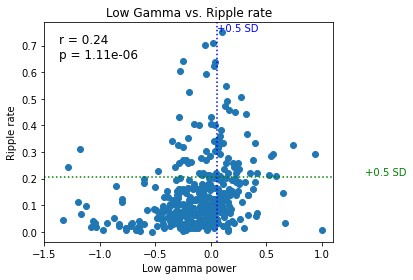

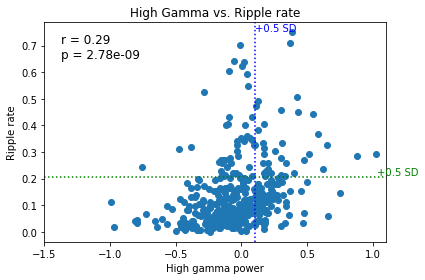

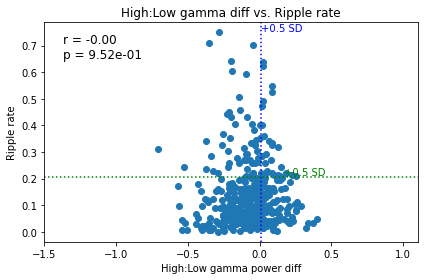

In [78]:
from scipy.stats import pearsonr

num_sd_line = 0.5  # Adjust this value to change the number of SDs
xlim = [-1.5,1.1]


## low gamma vs. ripple rate ##
correlation_coefficient, p_value = pearsonr(sub_low_gamma_elecs, sub_ripple_elecs)

plt.scatter(sub_low_gamma_elecs, sub_ripple_elecs)
plt.title("Low Gamma vs. Ripple rate")
annotation_text = f"r = {correlation_coefficient:.2f}\np = {p_value:.2e}"

# Fit a linear regression line and plot it
slope, intercept = np.polyfit(sub_low_gamma_elecs, sub_ripple_elecs, 1)
fit_line = np.array(sub_low_gamma_elecs) * slope + intercept
# plt.plot(sub_low_gamma_elecs, fit_line, color='red', linestyle='--', label='Linear fit')
plt.annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, verticalalignment='top')

# Calculate the mean and standard deviation for both variables
mean_low_gamma = np.mean(sub_low_gamma_elecs)
std_low_gamma = np.std(sub_low_gamma_elecs)
mean_high_gamma = np.mean(sub_high_gamma_elecs)
std_high_gamma = np.std(sub_high_gamma_elecs)
mean_ripple = np.mean(sub_ripple_elecs)
std_ripple = np.std(sub_ripple_elecs)
high_low_gamma_diff = np.array(sub_low_gamma_elecs) - np.array(sub_high_gamma_elecs)
mean_diff = np.mean(high_low_gamma_diff)
std_diff = np.std(high_low_gamma_diff)

# Plot the ±num_sd_line lines for sub_low_gamma_elecs
ylim = plt.ylim()
plt.axvline(mean_low_gamma + num_sd_line * std_low_gamma, color='blue', linestyle=':', label=f'+{num_sd_line} SD Low Gamma')
plt.text(mean_low_gamma + num_sd_line * std_low_gamma, ylim[1] - (ylim[1] - ylim[0]) * 0.05, 
         f'+{num_sd_line} SD', color='blue', ha='left', va='bottom')
# plt.axvline(mean_low_gamma - num_sd_line * std_low_gamma, color='blue', linestyle=':', label=f'-{num_sd_line} SD Low Gamma')
# plt.text(mean_low_gamma - num_sd_line * std_low_gamma, ylim[1] - (ylim[1] - ylim[0]) * 0.05, 
#          f'-{num_sd_line} SD', color='blue', ha='right', va='bottom')
plt.axhline(mean_ripple + num_sd_line * std_ripple, color='green', linestyle=':', label=f'+{num_sd_line} SD Ripple')
plt.text(plt.xlim()[1], mean_ripple + num_sd_line * std_ripple, f'+{num_sd_line} SD', color='green', ha='right', va='bottom')
# plt.axhline(mean_ripple - num_sd_line * std_ripple, color='green', linestyle=':', label=f'-{num_sd_line} SD Ripple')
# plt.text(plt.xlim()[1], mean_ripple - num_sd_line * std_ripple, f'-{num_sd_line} SD', color='green', ha='right', va='top')

plt.xlabel('Low gamma power')
plt.ylabel('Ripple rate')
plt.xlim(xlim)
plt.tight_layout(); plt.show()


## high gamma vs. ripple rate ##

correlation_coefficient, p_value = pearsonr(sub_high_gamma_elecs, sub_ripple_elecs)

plt.scatter(sub_high_gamma_elecs, sub_ripple_elecs)
plt.title("High Gamma vs. Ripple rate")
annotation_text = f"r = {correlation_coefficient:.2f}\np = {p_value:.2e}"

# Fit a linear regression line and plot it
slope, intercept = np.polyfit(sub_high_gamma_elecs, sub_ripple_elecs, 1)
fit_line = np.array(sub_high_gamma_elecs) * slope + intercept
# plt.plot(sub_high_gamma_elecs, fit_line, color='red', linestyle='--', label='Linear fit')
plt.annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, verticalalignment='top')

# Plot the ±num_sd_line lines for sub_low_gamma_elecs
ylim = plt.ylim()
plt.axvline(mean_high_gamma + num_sd_line * std_high_gamma, color='blue', linestyle=':', label=f'+{num_sd_line} SD Low Gamma')
plt.text(mean_high_gamma + num_sd_line * std_high_gamma, ylim[1] - (ylim[1] - ylim[0]) * 0.05, 
         f'+{num_sd_line} SD', color='blue', ha='left', va='bottom')
# plt.axvline(mean_high_gamma - num_sd_line * std_high_gamma, color='blue', linestyle=':', label=f'-{num_sd_line} SD Low Gamma')
# plt.text(mean_high_gamma - num_sd_line * std_high_gamma, ylim[1] - (ylim[1] - ylim[0]) * 0.05, 
#          f'-{num_sd_line} SD', color='blue', ha='right', va='bottom')
plt.axhline(mean_ripple + num_sd_line * std_ripple, color='green', linestyle=':', label=f'+{num_sd_line} SD Ripple')
plt.text(plt.xlim()[1], mean_ripple + num_sd_line * std_ripple, f'+{num_sd_line} SD', color='green', ha='right', va='bottom')
# plt.axhline(mean_ripple - num_sd_line * std_ripple, color='green', linestyle=':', label=f'-{num_sd_line} SD Ripple')
# plt.text(plt.xlim()[1], mean_ripple - num_sd_line * std_ripple, f'-{num_sd_line} SD', color='green', ha='right', va='top')

plt.xlabel('High gamma power')
plt.ylabel('Ripple rate')
plt.xlim(xlim)
plt.tight_layout(); plt.show()


## high:low gamma ratio vs. ripple rate ##

correlation_coefficient, p_value = pearsonr(high_low_gamma_diff, sub_ripple_elecs)

plt.scatter(high_low_gamma_diff, sub_ripple_elecs)
plt.title("High:Low gamma diff vs. Ripple rate")
annotation_text = f"r = {correlation_coefficient:.2f}\np = {p_value:.2e}"

# Fit a linear regression line and plot it
slope, intercept = np.polyfit(high_low_gamma_diff, sub_ripple_elecs, 1)
fit_line = np.array(high_low_gamma_diff) * slope + intercept
# plt.plot(sub_high_gamma_elecs, fit_line, color='red', linestyle='--', label='Linear fit')
plt.annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, verticalalignment='top')

# Plot the ±num_sd_line lines for sub_low_gamma_elecs
ylim = plt.ylim()
plt.axvline(mean_diff + num_sd_line * std_diff, color='blue', linestyle=':', label=f'+{num_sd_line} SD diff')
plt.text(mean_diff + num_sd_line * std_diff, ylim[1] - (ylim[1] - ylim[0]) * 0.05, 
         f'+{num_sd_line} SD', color='blue', ha='left', va='bottom')
# plt.axvline(mean_high_gamma - num_sd_line * std_high_gamma, color='blue', linestyle=':', label=f'-{num_sd_line} SD Low Gamma')
# plt.text(mean_high_gamma - num_sd_line * std_high_gamma, ylim[1] - (ylim[1] - ylim[0]) * 0.05, 
#          f'-{num_sd_line} SD', color='blue', ha='right', va='bottom')
plt.axhline(mean_ripple + num_sd_line * std_ripple, color='green', linestyle=':', label=f'+{num_sd_line} SD Ripple')
plt.text(plt.xlim()[1], mean_ripple + num_sd_line * std_ripple, f'+{num_sd_line} SD', color='green', ha='right', va='bottom')
# plt.axhline(mean_ripple - num_sd_line * std_ripple, color='green', linestyle=':', label=f'-{num_sd_line} SD Ripple')
# plt.text(plt.xlim()[1], mean_ripple - num_sd_line * std_ripple, f'-{num_sd_line} SD', color='green', ha='right', va='top')

plt.xlabel('High:Low gamma power diff')
plt.ylabel('Ripple rate')
plt.xlim(xlim)
plt.tight_layout(); plt.show()

a=1;

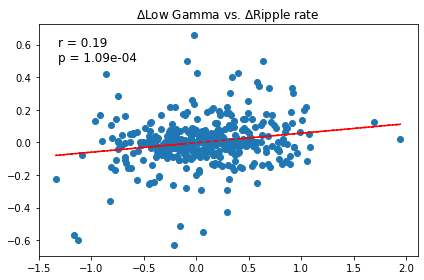

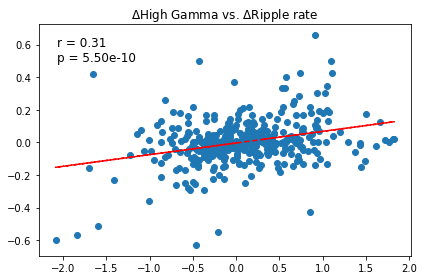

In [79]:
# delta(low gamma) vs. delta(ripple rate) (where both deltas are clust - unclust recalls)
correlation_coefficient, p_value = pearsonr(sub_low_gamma_elecs_clust_diff, sub_ripple_elecs_clust_diff)

plt.scatter(sub_low_gamma_elecs_clust_diff, sub_ripple_elecs_clust_diff)
plt.title(r"$\Delta$Low Gamma vs. $\Delta$Ripple rate")
annotation_text = f"r = {correlation_coefficient:.2f}\np = {p_value:.2e}"
plt.annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, verticalalignment='top')
# Fit a linear regression line and plot it
slope, intercept = np.polyfit(sub_low_gamma_elecs_clust_diff, sub_ripple_elecs_clust_diff, 1)
fit_line = np.array(sub_low_gamma_elecs_clust_diff) * slope + intercept
plt.plot(sub_low_gamma_elecs_clust_diff, fit_line, color='red', linestyle='--', label='Linear fit')
plt.tight_layout(); plt.show()

# high gamma vs. ripple rate
correlation_coefficient, p_value = pearsonr(sub_high_gamma_elecs_clust_diff, sub_ripple_elecs_clust_diff)

plt.scatter(sub_high_gamma_elecs_clust_diff, sub_ripple_elecs_clust_diff)
plt.title(r"$\Delta$High Gamma vs. $\Delta$Ripple rate")
annotation_text = f"r = {correlation_coefficient:.2f}\np = {p_value:.2e}"
plt.annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, verticalalignment='top')
# Fit a linear regression line and plot it
slope, intercept = np.polyfit(sub_high_gamma_elecs_clust_diff, sub_ripple_elecs_clust_diff, 1)
fit_line = np.array(sub_high_gamma_elecs_clust_diff) * slope + intercept
plt.plot(sub_high_gamma_elecs_clust_diff, fit_line, color='red', linestyle='--', label='Linear fit')
plt.tight_layout(); plt.show()

a=1;

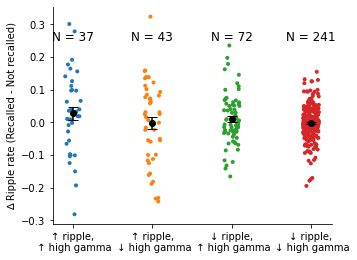

In [136]:
# Define quadrants

# 1 for low_gamma, 2 for high_gamma, 3 for high:low difference
low_gamma_on = 2
# 1 for clust v. not clust; 2 for recalled v. not recalled
clust_or_recalled = 2

if low_gamma_on == 1:
    quadrant_1 = (sub_low_gamma_elecs > mean_low_gamma + num_sd_line * std_low_gamma) & \
                 (sub_ripple_elecs > mean_ripple + num_sd_line * std_ripple)
    label1 = '↑ ripple,\n ↑ low gamma'
    quadrant_2 = (sub_low_gamma_elecs < mean_low_gamma + num_sd_line * std_low_gamma) & \
                 (sub_ripple_elecs > mean_ripple + num_sd_line * std_ripple)
    label2 = '↑ ripple,\n ↓ low gamma'
    quadrant_3 = (sub_low_gamma_elecs > mean_low_gamma + num_sd_line * std_low_gamma) & \
                 (sub_ripple_elecs < mean_ripple + num_sd_line * std_ripple)
    label3 = '↓ ripple,\n ↑ low gamma'
    quadrant_4 = (sub_low_gamma_elecs < mean_low_gamma + num_sd_line * std_low_gamma) & \
                 (sub_ripple_elecs < mean_ripple + num_sd_line * std_ripple)
    label4 = '↓ ripple,\n ↓ low gamma'
elif low_gamma_on == 2:
    quadrant_1 = (sub_high_gamma_elecs > mean_high_gamma + num_sd_line * std_high_gamma) & \
                 (sub_ripple_elecs > mean_ripple + num_sd_line * std_ripple)
    label1 = '↑ ripple,\n ↑ high gamma'
    quadrant_2 = (sub_high_gamma_elecs < mean_high_gamma + num_sd_line * std_high_gamma) & \
                 (sub_ripple_elecs > mean_ripple + num_sd_line * std_ripple)
    label2 = '↑ ripple,\n ↓ high gamma'
    quadrant_3 = (sub_high_gamma_elecs > mean_high_gamma + num_sd_line * std_high_gamma) & \
                 (sub_ripple_elecs < mean_ripple + num_sd_line * std_ripple)
    label3 = '↓ ripple,\n ↑ high gamma'
    quadrant_4 = (sub_high_gamma_elecs < mean_high_gamma + num_sd_line * std_high_gamma) & \
                 (sub_ripple_elecs < mean_ripple + num_sd_line * std_ripple)
    label4 = '↓ ripple,\n ↓ high gamma'
elif low_gamma_on == 3:
    quadrant_1 = (high_low_gamma_diff > mean_diff + num_sd_line * std_diff) & \
                 (sub_ripple_elecs > mean_ripple + num_sd_line * std_ripple)
    label1 = '↑ ripple,\n ↑ diff'
    quadrant_2 = (high_low_gamma_diff < mean_diff + num_sd_line * std_diff) & \
                 (sub_ripple_elecs > mean_ripple + num_sd_line * std_ripple)
    label2 = '↑ ripple,\n ↓ diff'
    quadrant_3 = (high_low_gamma_diff > mean_diff + num_sd_line * std_diff) & \
                 (sub_ripple_elecs < mean_ripple + num_sd_line * std_ripple)
    label3 = '↓ ripple,\n ↑ diff'
    quadrant_4 = (high_low_gamma_diff < mean_diff + num_sd_line * std_diff) & \
                 (sub_ripple_elecs < mean_ripple + num_sd_line * std_ripple)
    label4 = '↓ ripple,\n ↓ diff'
stats_labels = [
    label.replace('↑', 'High').replace('↓', 'Low').replace(',\n ', ' ')
    for label in labels]

# Initialize lists to store delta ripple rates for each quadrant
delta_ripple_quadrant_1 = []
delta_ripple_quadrant_2 = []
delta_ripple_quadrant_3 = []
delta_ripple_quadrant_4 = []

# Calculate delta ripple rates for each quadrant
final_subs = []
final_sess = []
for idx, elec in enumerate(min_trial_clust_elec):
    if clust_or_recalled == 1:
        delta_ripple = sub_ripple_elecs_clust_diff[idx] # lay all these out in the right order for ME model below
    else:
        if encoding_mode == 1:
            delta_ripple = sub_ripple_elecs_RECALLED_diff[idx] # lay all these out in the right order for ME model below
        else:
            print('Recall_mode is on so you cannot do SME (recalled v. not recalled)!!')
            error
    final_subs.append(min_trials_clust_subs[idx])
    final_sess.append(min_trials_clust_sess[idx])
    
    if quadrant_1[idx]:
        delta_ripple_quadrant_1.append(delta_ripple)
    elif quadrant_2[idx]:
        delta_ripple_quadrant_2.append(delta_ripple)
    elif quadrant_3[idx]:
        delta_ripple_quadrant_3.append(delta_ripple)
    elif quadrant_4[idx]:
        delta_ripple_quadrant_4.append(delta_ripple)


# Calculate mean and SE for each quadrant
mean_quadrant_1 = np.mean(delta_ripple_quadrant_1)
mean_quadrant_2 = np.mean(delta_ripple_quadrant_2)
mean_quadrant_3 = np.mean(delta_ripple_quadrant_3)
mean_quadrant_4 = np.mean(delta_ripple_quadrant_4)

se_quadrant_1 = np.std(delta_ripple_quadrant_1) / np.sqrt(len(delta_ripple_quadrant_1))
se_quadrant_2 = np.std(delta_ripple_quadrant_2) / np.sqrt(len(delta_ripple_quadrant_2))
se_quadrant_3 = np.std(delta_ripple_quadrant_3) / np.sqrt(len(delta_ripple_quadrant_3))
se_quadrant_4 = np.std(delta_ripple_quadrant_4) / np.sqrt(len(delta_ripple_quadrant_4))

# Combine the data into a single list and create labels
delta_ripple_data = (
    delta_ripple_quadrant_1 +
    delta_ripple_quadrant_2 +
    delta_ripple_quadrant_3 +
    delta_ripple_quadrant_4
)

labels = (
    [label1] * len(delta_ripple_quadrant_1) +
    [label2] * len(delta_ripple_quadrant_2) +
    [label3] * len(delta_ripple_quadrant_3) +
    [label4] * len(delta_ripple_quadrant_4)
)

# Plot the swarm plot
fig, ax = plt.subplots(figsize=(5, 4))
sb.stripplot(x=labels, y=delta_ripple_data, ax=ax, size=4)

# Plot the means and SEs over the swarm plot
means = [mean_quadrant_1, mean_quadrant_2, mean_quadrant_3, mean_quadrant_4]
ses = [se_quadrant_1, se_quadrant_2, se_quadrant_3, se_quadrant_4]
x_positions = [0, 1, 2, 3]

ax.errorbar(x_positions, means, yerr=ses, fmt='o', color='black', capsize=5, zorder=10)

# Add "N = XXX" over the top of each bar
num_electrodes = [len(delta_ripple_quadrant_1), len(delta_ripple_quadrant_2), len(delta_ripple_quadrant_3), len(delta_ripple_quadrant_4)]
for i, num in enumerate(num_electrodes):
    ax.text(i, 0.25, f'N = {num}', ha='center', fontsize=12, color='black')

if clust_or_recalled == 1:
    ax.set_ylabel('∆ Ripple rate (Clustered - Unclustered)')
else:
    ax.set_ylabel('∆ Ripple rate (Recalled - Not recalled)')
# ax.set_title('Delta Ripple Rate by Quadrant')
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.show();

In [131]:
import statsmodels.formula.api as smf

# Prepare the data in a DataFrame for the mixed effects model
data = pd.DataFrame({
    'delta_ripple': delta_ripple_data,
    'label': stats_labels,
    'subject': [str(sub) for sub in final_subs],
    'session': [str(sess) for sess in final_sess]
})
# create separate predictors dependent on data compiled above
data['high_ripple'] = data['label'].apply(lambda x: 1 if 'High ripple' in x else 0)

# Specify the formula for the mixed effects model
vc_formula = {"C(session)": "0 + C(session)"}
if low_gamma_on==1:
    data['low_gamma'] = data['label'].apply(lambda x: 1 if 'High low' in x else 0)
    equation = 'delta_ripple ~ high_ripple*low_gamma'
elif low_gamma_on==2:
    data['high_gamma'] = data['label'].apply(lambda x: 1 if 'High high' in x else 0)
    equation = 'delta_ripple ~ high_ripple*high_gamma'
elif low_gamma_on==3:
    data['high_diff'] = data['label'].apply(lambda x: 1 if 'High diff' in x else 0)
    equation = 'delta_ripple ~ high_ripple*high_diff'
model = smf.mixedlm(equation,data, groups=data['subject'],vc_formula=vc_formula) #,re_formula="label")
result = model.fit()
print(result.summary())

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   delta_ripple
No. Observations:    393       Method:               REML        
No. Groups:          86        Scale:                0.0059      
Min. group size:     1         Log-Likelihood:       437.0413    
Max. group size:     21        Converged:            Yes         
Mean group size:     4.6                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              -0.003    0.005 -0.576 0.565 -0.013  0.007
high_ripple             0.000    0.013  0.015 0.988 -0.025  0.026
high_gamma              0.013    0.012  1.063 0.288 -0.011  0.036
high_ripple:high_gamma  0.017    0.021  0.814 0.415 -0.024  0.058
C(session) Var          0.000    0.004                           



/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


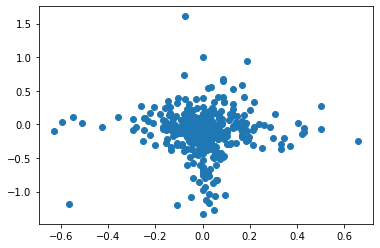

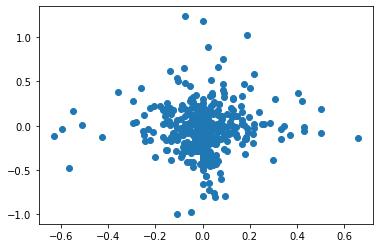

In [82]:
# Assuming min_trial_elecs and min_trial_clust_elec are your lists
idxs_in_first = np.array([min_trial_elecs.index(label) for label in min_trial_clust_elec if label in min_trial_elecs])

plt.scatter(sub_ripple_elecs_clust_diff,np.array(sub_low_gamma_elecs)[idxs_in_first]); plt.show()
plt.scatter(sub_ripple_elecs_clust_diff,np.array(sub_high_gamma_elecs)[idxs_in_first])

In [83]:
remove_low_freq = 1 # 1 for low gamma/theta; 2 for high gamma/theta

# ripples after removing low gamma trials

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: RuntimeWarning: invalid value encountered in true_divide
  norm_count = count/np.array((num_trials*binsize/1000))
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: RuntimeWarning: divide by zero encountered in true_divide
  norm_count = count/np.array((num_trials*binsize/1000))


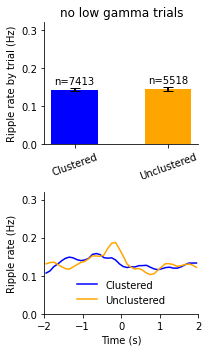

In [152]:
import matplotlib.gridspec as gridspec

# Function parameters
bin_size = 100  # in ms
smoothing_triangle = 5  # triangular smoothing window width

bar_ylimits = (0, 0.32)

if remove_low_freq == 1:
    trial_select = ~z_low_gamma_trials
elif remove_low_freq == 2:
    trial_select = ~z_high_gamma_trials
else:
    print('Invalid remove_low_freq selection')
    error    

ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)
ripple_swarm_duration = (ripple_analysis_end-ripple_analysis_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = sub_clust_ID > 1
clust_unclustered = sub_clust_ID < 0
clust_not_recalled = sub_clust_ID == 0

# Calculate ripple means and standard errors for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select & clust_not_recalled, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

if encoding_mode == 1:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered), np.mean(mean_ripple_not_recalled)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered)),
           np.std(mean_ripple_not_recalled) / np.sqrt(len(mean_ripple_not_recalled))]
    fig = plt.figure(figsize=(4, 5))
elif encoding_mode == 0:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered))]    
    fig = plt.figure(figsize=(3, 5))

# Define the palette for colors
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}

# Set up the figure with GridSpec
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 2], width_ratios=[3, 3, 3])

# Create the bar plot with error bars (span all columns)
ax_bar = fig.add_subplot(gs[0, :])
if encoding_mode == 1:
    xlabels = ['Clustered', 'Unclustered', 'Not Recalled']
    xcolors = [palette['Clustered'], palette['Unclustered'], palette['Not Recalled']]
elif encoding_mode == 0:
    xlabels = ['Clustered', 'Unclustered']
    xcolors = [palette['Clustered'], palette['Unclustered']]
bars = ax_bar.bar(x=xlabels, 
                  height=means, 
                  color=xcolors, 
                  yerr=ses, 
                  width=0.5,  # Adjust width to make bars tighter
                  capsize=5, 
                  error_kw=dict(ecolor='black', elinewidth=2))

ax_bar.set_ylabel('Ripple rate by trial (Hz)')
ax_bar.set_xlabel('')
ax_bar.set_ylim(bar_ylimits)
ax_bar.set_xticklabels(['Clustered', 'Unclustered', 'Not Recalled'], rotation=20, ha="center")
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.set_title('no low gamma trials')

# Add the number of trials above each bar
n_trials = [np.sum(trial_select & clust_clustered), 
            np.sum(trial_select & clust_unclustered), 
            np.sum(trial_select & clust_not_recalled)]
for bar, n in zip(bars, n_trials):
    ax_bar.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'n={n}', ha='center', va='bottom')

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Plot the PSTH for each group
ax_psth = fig.add_subplot(gs[1, :])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_clustered, label='Clustered', color=palette['Clustered'])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_unclustered, label='Unclustered', color=palette['Unclustered'])
if encoding_mode == 1:
    ax_psth.plot(bin_centers / 1000, ripple_PSTH_not_recalled, label='Not Recalled', color=palette['Not Recalled'])
    ax_psth.axvline(x=0.0, color='black', linestyle='--')
    ax_psth.axvline(x=1.6, color='black', linestyle='--')
    ax_psth.set_xlim(-0.25, 2.05)
elif encoding_mode == 0:
    ax_psth.set_xlim(-2.0, 2.0)
ax_psth.set_xlabel('Time (s)')
ax_psth.set_ylim(0,bar_ylimits[1])
ax_psth.set_ylabel('Ripple rate (Hz)')
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Add legend to the bottom plot
ax_psth.legend(loc='lower center', frameon=False)

# Adjust layout
plt.tight_layout()
plt.show()
a=1;

# ripples only for + low gamma trials

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: conve

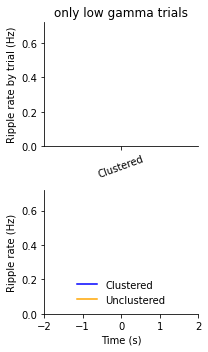

In [153]:
# Function parameters
bin_size = 100  # in ms
smoothing_triangle = 5  # triangular smoothing window width

bar_ylimits = (0, 0.72)

if remove_low_freq == 1:
    trial_select = z_low_gamma_trials
elif remove_low_freq == 2:
    trial_select = z_high_gamma_trials
else:
    print('Invalid remove_low_freq selection')
    error

ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)
ripple_swarm_duration = (ripple_analysis_end-ripple_analysis_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = sub_clust_ID > 1
clust_unclustered = sub_clust_ID < 0
clust_not_recalled = sub_clust_ID == 0

# Calculate ripple means and standard errors for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select & clust_not_recalled, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

if encoding_mode == 1:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered), np.mean(mean_ripple_not_recalled)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered)),
           np.std(mean_ripple_not_recalled) / np.sqrt(len(mean_ripple_not_recalled))]
    fig = plt.figure(figsize=(4, 5))
elif encoding_mode == 0:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered))]    
    fig = plt.figure(figsize=(3, 5))

# Define the palette for colors
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}

# Set up the figure with GridSpec
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 2], width_ratios=[3, 3, 3])

# Create the bar plot with error bars (span all columns)
ax_bar = fig.add_subplot(gs[0, :])
if encoding_mode == 1:
    xlabels = ['Clustered', 'Unclustered', 'Not Recalled']
    xcolors = [palette['Clustered'], palette['Unclustered'], palette['Not Recalled']]
elif encoding_mode == 0:
    xlabels = ['Clustered', 'Unclustered']
    xcolors = [palette['Clustered'], palette['Unclustered']]
bars = ax_bar.bar(x=xlabels, 
                  height=means, 
                  color=xcolors, 
                  yerr=ses, 
                  width=0.5,  # Adjust width to make bars tighter
                  capsize=5, 
                  error_kw=dict(ecolor='black', elinewidth=2))

ax_bar.set_ylabel('Ripple rate by trial (Hz)')
ax_bar.set_xlabel('')
ax_bar.set_ylim(bar_ylimits)
ax_bar.set_xticklabels(xlabels, rotation=20, ha="center")
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.set_title('only low gamma trials')

# Add the number of trials above each bar
n_trials = [np.sum(trial_select & clust_clustered), 
            np.sum(trial_select & clust_unclustered), 
            np.sum(trial_select & clust_not_recalled)]
for bar, n in zip(bars, n_trials):
    ax_bar.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.03, f'n={n}', ha='center', va='bottom')

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Plot the PSTH for each group
ax_psth = fig.add_subplot(gs[1, :])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_clustered, label='Clustered', color=palette['Clustered'])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_unclustered, label='Unclustered', color=palette['Unclustered'])
if encoding_mode == 1:
    ax_psth.plot(bin_centers / 1000, ripple_PSTH_not_recalled, label='Not Recalled', color=palette['Not Recalled'])
    ax_psth.axvline(x=0.0, color='black', linestyle='--')
    ax_psth.axvline(x=1.6, color='black', linestyle='--')
    ax_psth.set_xlim(-0.25, 2.05)
elif encoding_mode == 0:
    ax_psth.set_xlim(-2.0, 2.0)
ax_psth.set_xlabel('Time (s)')
ax_psth.set_ylim(0,bar_ylimits[1])
ax_psth.set_ylabel('Ripple rate (Hz)')
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Add legend to the bottom plot
ax_psth.legend(loc='lower center', frameon=False)

# Adjust layout
plt.tight_layout()
plt.show()
a=1;

In [86]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Flatten the ripple data for easier modeling
ripple_data = start_array[:, ripple_swarm_start:ripple_swarm_end].sum(axis=1)

# Create a DataFrame with the data
df = pd.DataFrame({
    'ripple_rate': ripple_data,
    'clust_clustered': (sub_clust_ID > 1).astype(int),
    'clust_unclustered': (sub_clust_ID < 0).astype(int),
    'clust_not_recalled': (sub_clust_ID == 0).astype(int),
    'session': dd_trials['sess'][final_sub_idxs],
    'subject': dd_trials['subj'][final_sub_idxs],
    'low_gamma': z_low_gamma_trials,
})
if remove_low_freq == 2:
    df['high_gamma'] = z_high_gamma_trials

# Define the model formula
# 'ripple_rate ~ clust_clustered + clust_unclustered + clust_not_recalled' specifies the fixed effects
# '(1 | subject/session)' specifies the random effects, with session nested within subject
if encoding_mode == 1:
    formula = "ripple_rate ~ clust_clustered + clust_unclustered"
elif encoding_mode == 0:
    formula = "ripple_rate ~ clust_clustered" # since not recalled doesn't exist
model = mixedlm(
    formula=formula,data=df, groups=df["subject"], vc_formula={"session": "0 + session"})

print(model.fit().summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  ripple_rate
No. Observations:  81984    Method:              REML       
No. Groups:        100      Scale:               0.1816     
Min. group size:   84       Log-Likelihood:      -46744.6332
Max. group size:   3360     Converged:           Yes        
Mean group size:   819.8                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.138    0.008 17.820 0.000  0.123  0.153
clust_clustered    0.000    0.004  0.016 0.987 -0.009  0.009
clust_unclustered -0.005    0.005 -1.005 0.315 -0.013  0.004
session Var        0.012    0.003                           



In [87]:
if encoding_mode == 1:
    if remove_low_freq == 1:
        formula = "ripple_rate ~ low_gamma*(clust_clustered + clust_unclustered)"
    elif remove_low_freq == 2:
        formula = "ripple_rate ~ high_gamma*(clust_clustered + clust_unclustered)"
elif encoding_mode == 0:
    if remove_low_freq == 1:
        formula = "ripple_rate ~ low_gamma*clust_clustered" # since not recalled doesn't exist
    elif remove_low_freq == 2:
        formula = "ripple_rate ~ high_gamma*clust_clustered" # since not recalled doesn't exist
model = mixedlm(
    formula=formula,data=df, groups=df["subject"], vc_formula={"session": "0 + session"})

print(model.fit().summary())

                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        ripple_rate
No. Observations:        81984          Method:                    REML       
No. Groups:              100            Scale:                     0.1768     
Min. group size:         84             Log-Likelihood:            -45659.3860
Max. group size:         3360           Converged:                 Yes        
Mean group size:         819.8                                                
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            0.110    0.008 14.330 0.000  0.095  0.125
low_gamma[T.True]                    0.211    0.005 41.148 0.000  0.201  0.221
clust_clustered                      0.000    0.005  0.069 0.945 -0.009  

# make plots like in the PNAS 2022 paper

/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))


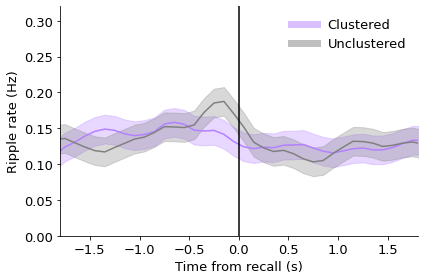

In [185]:
save_plot = 1

constant_error = 0.02

# Configuration parameters
bin_size = 100  # in ms
smoothing_triangle = 5  # triangular smoothing window width
font_size = 13  # Settable font size
bar_ylimits = (0, 0.32)

if remove_low_freq == 1:
    trial_select = ~z_low_gamma_trials
elif remove_low_freq == 2:
    trial_select = ~z_high_gamma_trials
else:
    print('Invalid remove_low_freq selection')
    error    

ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)
ripple_swarm_duration = (ripple_analysis_end-ripple_analysis_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = sub_clust_ID > 1
clust_unclustered = sub_clust_ID < 0

# Calculate ripple means for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Set up the figure with GridSpec
fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(1, 1)
ax_psth = fig.add_subplot(gs[0, 0])

# Define the custom colors
if region_name[0] == 'HPC':
    high_clustered_color = (0.0, 0.5, 0.0) # green
elif region_name[0] == 'ENT':
    high_clustered_color = (0.7, 0.5, 1.0) # Light purple
low_clustering_color = 'gray'  

# Plot the PSTH for each group
ax_psth.plot(bin_centers / 1000, ripple_PSTH_clustered, label='Clustered', color=high_clustered_color)
ax_psth.plot(bin_centers / 1000, ripple_PSTH_unclustered, label='Unclustered', color=low_clustering_color)

# Add constant error bands using fill_between
ax_psth.fill_between(bin_centers / 1000, ripple_PSTH_clustered - constant_error, ripple_PSTH_clustered + constant_error,
                     color=high_clustered_color, alpha=0.3, label='_nolegend_')
ax_psth.fill_between(bin_centers / 1000, ripple_PSTH_unclustered - constant_error, ripple_PSTH_unclustered + constant_error,
                     color=low_clustering_color, alpha=0.3, label='_nolegend_')

# Add labels and formatting
ax_psth.axvline(x=0.0, color='black', linestyle='-')
ax_psth.set_xlabel('Time from recall (s)', fontsize=font_size)
ax_psth.set_ylabel('Ripple rate (Hz)', fontsize=font_size)
ax_psth.set_xlim(-1.8, 1.8)
ax_psth.set_ylim(0, bar_ylimits[1])
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Customize ticks
ax_psth.set_xticks(np.arange(-1.5, 2.0, 0.5))
ax_psth.set_yticks(np.arange(0, 0.35, 0.05))
ax_psth.tick_params(axis='both', labelsize=font_size)
leg = ax_psth.legend(frameon=False, fontsize=font_size)
for legobj in leg.legendHandles:
    legobj.set_linewidth(7.0)
    legobj.set_alpha(0.5)

# Adjust layout and show plot
plt.tight_layout()

if save_plot == 1:
    plt.savefig(f'/home1/john/SWRrefactored/figures/ripple_psths/{task}_{saveName}{region_name[0]}_{subregion[0]}_allTrials.pdf',transparent=True) 

plt.show();
